# cora sgeniepath agnn

In [3]:
%%time
import argparse
import os.path as osp

import torch
from torch_geometric.datasets import PPI
from torch_geometric.data import DataLoader
from torch_geometric.nn import GATConv,AGNNConv
from sklearn.metrics import f1_score
from torch_geometric.datasets import Planetoid
import torch.nn.functional as F
import torch_geometric.transforms as T

# parser = argparse.ArgumentParser()
# parser.add_argument('--model', type=str, default='GeniePath')
# args = parser.parse_args()
# assert args.model in ['GeniePath', 'GeniePathLazy']

# path = osp.join(osp.dirname(osp.realpath(__file__)), 'data', 'PPI')
# train_dataset = PPI(path, split='train')
# val_dataset = PPI(path, split='val')
# test_dataset = PPI(path, split='test')
# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

dataset = 'Cora'
path = osp.join('./', '..', 'data', dataset)
dataset = Planetoid(path, dataset, T.NormalizeFeatures())
data = dataset[0]

# dim = dataset.num_features
# lstm_hidden = dataset.num_features
dim = 128
lstm_hidden = 128
layer_num = 2 #pubmed为3效果比较好，cora不能超过2,Citeseer不能超过1


class Breadth(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Breadth, self).__init__()
        self.gatconv = AGNNConv(requires_grad=True)
        # self.gatconv = GATConv(in_dim, out_dim,dropout=0.4, heads=1)#这里in_dim和out_dim都=dim=256

    def forward(self, x, edge_index):
        x=F.dropout(x, p=0.4, training=self.training)
        x = torch.tanh(self.gatconv(x, edge_index))
        return x


class Depth(torch.nn.Module):
    def __init__(self, in_dim, hidden):
        super(Depth, self).__init__()
        self.lstm = torch.nn.LSTM(in_dim, hidden, 1, bias=False)

    def forward(self, x, h, c):
        x=F.dropout(x, p=0.4, training=self.training)

        x, (h, c) = self.lstm(x, (h, c))
        return x, (h, c)


class GeniePathLayer(torch.nn.Module):
    def __init__(self, in_dim):
        super(GeniePathLayer, self).__init__()
        self.breadth_func = Breadth(in_dim, dim)
        self.depth_func = Depth(dim, lstm_hidden)

    def forward(self, x, edge_index, h, c):
        x = self.breadth_func(x, edge_index)
        x = x[None, :]
        x, (h, c) = self.depth_func(x, h, c)
        x = x[0]
        return x, (h, c)


class GeniePath(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePath, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.gplayers = torch.nn.ModuleList(
            [GeniePathLayer(dim) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x=F.dropout(x, p=0.4, training=self.training)

        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        for i, l in enumerate(self.gplayers):
            x, (h, c) = self.gplayers[i](x, edge_index, h, c)
        x = self.lin2(x)
        # return x
        return F.log_softmax(x, dim=1)



class GeniePathLazy(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePathLazy, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.breadths = torch.nn.ModuleList(
            [Breadth(dim, dim) for i in range(layer_num)])
        self.depths = torch.nn.ModuleList(
            [Depth(dim * 2, lstm_hidden) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        h_tmps = []
        for i, l in enumerate(self.breadths):
            h_tmps.append(self.breadths[i](x, edge_index))
        x = x[None, :]
        for i, l in enumerate(self.depths):
            in_cat = torch.cat((h_tmps[i][None, :], x), -1)
            x, (h, c) = self.depths[i](in_cat, h, c)
        x = self.lin2(x[0])
        return x


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kwargs = {'GeniePath': GeniePath, 'GeniePathLazy': GeniePathLazy}
# model = kwargs[args.model](train_dataset.num_features,train_dataset.num_classes).to(device)
loss_op = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model, data = GeniePath(dataset.num_features,dataset.num_classes).to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)


def train():
    model.train()
    optimizer.zero_grad()
    # loss = loss_op(model(data.x, data.edge_index), data.y)
    loss = F.nll_loss(model(data.x, data.edge_index)[data.train_mask], data.y[data.train_mask])
    # loss = loss_op(model(data.x, data.edge_index)[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss 


def test():
    model.eval()
    logits, accs = model(data.x, data.edge_index), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        a=logits[mask]
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

losslist_cora_mymodel,testacclist_cora_mymodel=[],[]
for epoch in range(1, 1001):
    loss = train()
    losslist_cora_mymodel.append(loss)
    testacclist_cora_mymodel.append(test()[2])
    # val_f1 = test(val_loader)
    # test_f1 = test(test_loader)
    # print('Epoch: {:02d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'.format(
    #     epoch, loss, val_f1, test_f1))
    log = 'Epoch: {:03d},train_loss:{:.7f}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    print(log.format(epoch, loss,*test()))
# from matplotlib import pyplot as plt 
# # %matplotlib inline

# plt.plot(losslist)
# plt.show()



"""
1000轮cora数据集效果
Epoch: 979,train_loss:0.1637752, Train: 1.0000, Val: 0.7000, Test: 0.7280
Epoch: 980,train_loss:0.0791690, Train: 1.0000, Val: 0.7120, Test: 0.7390
Epoch: 981,train_loss:0.0635783, Train: 1.0000, Val: 0.7240, Test: 0.7450
Epoch: 982,train_loss:0.0318759, Train: 1.0000, Val: 0.7340, Test: 0.7460
Epoch: 983,train_loss:0.0955521, Train: 1.0000, Val: 0.7500, Test: 0.7570
Epoch: 984,train_loss:0.0810624, Train: 1.0000, Val: 0.7500, Test: 0.7670
Epoch: 985,train_loss:0.0891033, Train: 1.0000, Val: 0.7640, Test: 0.7750
Epoch: 986,train_loss:0.0739494, Train: 1.0000, Val: 0.7600, Test: 0.7830
Epoch: 987,train_loss:0.0990233, Train: 1.0000, Val: 0.7560, Test: 0.7770
Epoch: 988,train_loss:0.0988771, Train: 1.0000, Val: 0.7520, Test: 0.7710
Epoch: 989,train_loss:0.0732601, Train: 1.0000, Val: 0.7520, Test: 0.7650
Epoch: 990,train_loss:0.0788579, Train: 1.0000, Val: 0.7640, Test: 0.7680
Epoch: 991,train_loss:0.0499137, Train: 1.0000, Val: 0.7620, Test: 0.7670
Epoch: 992,train_loss:0.0951503, Train: 1.0000, Val: 0.7540, Test: 0.7560
Epoch: 993,train_loss:0.1640868, Train: 1.0000, Val: 0.7500, Test: 0.7520
Epoch: 994,train_loss:0.1025555, Train: 1.0000, Val: 0.7420, Test: 0.7400
Epoch: 995,train_loss:0.0693817, Train: 1.0000, Val: 0.7480, Test: 0.7430
Epoch: 996,train_loss:0.0883153, Train: 1.0000, Val: 0.7560, Test: 0.7580
Epoch: 997,train_loss:0.1922379, Train: 1.0000, Val: 0.7540, Test: 0.7570
Epoch: 998,train_loss:0.0917486, Train: 1.0000, Val: 0.7540, Test: 0.7560
Epoch: 999,train_loss:0.1085564, Train: 1.0000, Val: 0.7500, Test: 0.7570
Epoch: 1000,train_loss:0.0600472, Train: 1.0000, Val: 0.7560, Test: 0.7610
[1]    5346 terminated  env PYTHONIOENCODING=UTF-8 PYTHONUNBUFFERED=1   --default --client --host    
Wall time: 25.2 s

"""


sum([torch.numel(param) for param in model.parameters()])







Epoch: 001,train_loss:1.9464262, Train: 0.1429, Val: 0.1220, Test: 0.1300
Epoch: 002,train_loss:1.9461441, Train: 0.1429, Val: 0.1220, Test: 0.1300
Epoch: 003,train_loss:1.9459273, Train: 0.1429, Val: 0.1220, Test: 0.1300
Epoch: 004,train_loss:1.9456735, Train: 0.1714, Val: 0.1220, Test: 0.1330
Epoch: 005,train_loss:1.9455956, Train: 0.2286, Val: 0.1260, Test: 0.1430
Epoch: 006,train_loss:1.9455638, Train: 0.3214, Val: 0.2140, Test: 0.2160
Epoch: 007,train_loss:1.9453977, Train: 0.1429, Val: 0.1620, Test: 0.1490
Epoch: 008,train_loss:1.9451876, Train: 0.1429, Val: 0.1620, Test: 0.1490
Epoch: 009,train_loss:1.9451252, Train: 0.1429, Val: 0.1620, Test: 0.1490
Epoch: 010,train_loss:1.9450195, Train: 0.1429, Val: 0.1620, Test: 0.1490
Epoch: 011,train_loss:1.9448973, Train: 0.1429, Val: 0.1620, Test: 0.1490
Epoch: 012,train_loss:1.9448318, Train: 0.1429, Val: 0.1640, Test: 0.1500
Epoch: 013,train_loss:1.9448287, Train: 0.2429, Val: 0.3320, Test: 0.3340
Epoch: 014,train_loss:1.9447016, Train

446601

# cora geniepath

In [1]:
%%time
import argparse
import os.path as osp

import torch
from torch_geometric.datasets import PPI
from torch_geometric.data import DataLoader
from torch_geometric.nn import GATConv,AGNNConv
from sklearn.metrics import f1_score
from torch_geometric.datasets import Planetoid
import torch.nn.functional as F
import torch_geometric.transforms as T

# parser = argparse.ArgumentParser()
# parser.add_argument('--model', type=str, default='GeniePath')
# args = parser.parse_args()
# assert args.model in ['GeniePath', 'GeniePathLazy']

# path = osp.join(osp.dirname(osp.realpath(__file__)), 'data', 'PPI')
# train_dataset = PPI(path, split='train')
# val_dataset = PPI(path, split='val')
# test_dataset = PPI(path, split='test')
# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

dataset = 'Cora'
path = osp.join('./', '..', 'data', dataset)
dataset = Planetoid(path, dataset, T.NormalizeFeatures())
data = dataset[0]

# dim = dataset.num_features
# lstm_hidden = dataset.num_features
dim = 128
lstm_hidden = 128
layer_num = 2  #pubmed为3效果比较好，cora不能超过2,Citeseer不能超过1


class Breadth(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Breadth, self).__init__()
        # self.gatconv = AGNNConv(requires_grad=True)
        self.gatconv = GATConv(in_dim, out_dim,dropout=0.4, heads=1)#这里in_dim和out_dim都=dim=256

    def forward(self, x, edge_index):
        x=F.dropout(x, p=0.4, training=self.training)
        x = torch.tanh(self.gatconv(x, edge_index))
        return x


class Depth(torch.nn.Module):
    def __init__(self, in_dim, hidden):
        super(Depth, self).__init__()
        self.lstm = torch.nn.LSTM(in_dim, hidden, 1, bias=False)

    def forward(self, x, h, c):
        x=F.dropout(x, p=0.4, training=self.training)

        x, (h, c) = self.lstm(x, (h, c))
        return x, (h, c)


class GeniePathLayer(torch.nn.Module):
    def __init__(self, in_dim):
        super(GeniePathLayer, self).__init__()
        self.breadth_func = Breadth(in_dim, dim)
        self.depth_func = Depth(dim, lstm_hidden)

    def forward(self, x, edge_index, h, c):
        x = self.breadth_func(x, edge_index)
        x = x[None, :]
        x, (h, c) = self.depth_func(x, h, c)
        x = x[0]
        return x, (h, c)


class GeniePath(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePath, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.gplayers = torch.nn.ModuleList(
            [GeniePathLayer(dim) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x=F.dropout(x, p=0.4, training=self.training)

        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        for i, l in enumerate(self.gplayers):
            x, (h, c) = self.gplayers[i](x, edge_index, h, c)
        x = self.lin2(x)
        # return x
        return F.log_softmax(x, dim=1)



class GeniePathLazy(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePathLazy, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.breadths = torch.nn.ModuleList(
            [Breadth(dim, dim) for i in range(layer_num)])
        self.depths = torch.nn.ModuleList(
            [Depth(dim * 2, lstm_hidden) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        h_tmps = []
        for i, l in enumerate(self.breadths):
            h_tmps.append(self.breadths[i](x, edge_index))
        x = x[None, :]
        for i, l in enumerate(self.depths):
            in_cat = torch.cat((h_tmps[i][None, :], x), -1)
            x, (h, c) = self.depths[i](in_cat, h, c)
        x = self.lin2(x[0])
        return x


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kwargs = {'GeniePath': GeniePath, 'GeniePathLazy': GeniePathLazy}
# model = kwargs[args.model](train_dataset.num_features,train_dataset.num_classes).to(device)
loss_op = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model, data = GeniePath(dataset.num_features,dataset.num_classes).to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)


def train():
    model.train()
    optimizer.zero_grad()
    # loss = loss_op(model(data.x, data.edge_index), data.y)
    loss = F.nll_loss(model(data.x, data.edge_index)[data.train_mask], data.y[data.train_mask])
    # loss = loss_op(model(data.x, data.edge_index)[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss 


def test():
    model.eval()
    logits, accs = model(data.x, data.edge_index), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        a=logits[mask]
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

losslist_cora_geniepath,testacclist_cora_geniepath=[],[]
for epoch in range(1, 1001):
    loss = train()
    losslist_cora_geniepath.append(loss)
    testacclist_cora_geniepath.append(test()[2])
    # val_f1 = test(val_loader)
    # test_f1 = test(test_loader)
    # print('Epoch: {:02d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'.format(
    #     epoch, loss, val_f1, test_f1))
    log = 'Epoch: {:03d},train_loss:{:.7f}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    print(log.format(epoch, loss,*test()))
# from matplotlib import pyplot as plt 
# %matplotlib inline
# f, ax = plt.subplots(1,2)

# ax[0][0].plot(losslist_cora_geniepath,label="losslist_cora_geniepath")
# ax[0][1].plot(testacclist_cora_geniepath,label="testacclist_cora_geniepath")
# plt.legend(loc=0, ncol=1) 
# plt.show()



"""
1000轮cora数据集效果
Epoch: 984,train_loss:0.0691620, Train: 1.0000, Val: 0.7180, Test: 0.7240
Epoch: 985,train_loss:0.0437133, Train: 1.0000, Val: 0.7220, Test: 0.7410
Epoch: 986,train_loss:0.0614745, Train: 1.0000, Val: 0.7200, Test: 0.7450
Epoch: 987,train_loss:0.1168561, Train: 1.0000, Val: 0.7120, Test: 0.7460
Epoch: 988,train_loss:0.1891420, Train: 1.0000, Val: 0.7140, Test: 0.7410
Epoch: 989,train_loss:0.1568069, Train: 1.0000, Val: 0.7240, Test: 0.7360
Epoch: 990,train_loss:0.0887830, Train: 1.0000, Val: 0.7300, Test: 0.7310
Epoch: 991,train_loss:0.1009816, Train: 1.0000, Val: 0.7220, Test: 0.7140
Epoch: 992,train_loss:0.0463423, Train: 1.0000, Val: 0.7120, Test: 0.7070
Epoch: 993,train_loss:0.1423967, Train: 1.0000, Val: 0.7060, Test: 0.7330
Epoch: 994,train_loss:0.0659238, Train: 1.0000, Val: 0.7200, Test: 0.7550
Epoch: 995,train_loss:0.1288171, Train: 1.0000, Val: 0.7280, Test: 0.7590
Epoch: 996,train_loss:0.0688528, Train: 1.0000, Val: 0.7300, Test: 0.7590
Epoch: 997,train_loss:0.0710301, Train: 1.0000, Val: 0.7300, Test: 0.7590
Epoch: 998,train_loss:0.1300182, Train: 1.0000, Val: 0.7300, Test: 0.7500
Epoch: 999,train_loss:0.1003017, Train: 1.0000, Val: 0.7260, Test: 0.7510
Epoch: 1000,train_loss:0.0455814, Train: 1.0000, Val: 0.7220, Test: 0.7460
CPU times: user 28.3 s, sys: 631 ms, total: 29 s
Wall time: 25.9 s


"""
sum([torch.numel(param) for param in model.parameters()])



Epoch: 001,train_loss:1.9478176, Train: 0.1429, Val: 0.0580, Test: 0.0640
Epoch: 002,train_loss:1.9472446, Train: 0.1429, Val: 0.0580, Test: 0.0640
Epoch: 003,train_loss:1.9468615, Train: 0.1429, Val: 0.0580, Test: 0.0640
Epoch: 004,train_loss:1.9465384, Train: 0.1429, Val: 0.0580, Test: 0.0640
Epoch: 005,train_loss:1.9461062, Train: 0.1429, Val: 0.0580, Test: 0.0640
Epoch: 006,train_loss:1.9459481, Train: 0.2786, Val: 0.1060, Test: 0.1370
Epoch: 007,train_loss:1.9456667, Train: 0.1429, Val: 0.0720, Test: 0.0910
Epoch: 008,train_loss:1.9454964, Train: 0.1429, Val: 0.0720, Test: 0.0910
Epoch: 009,train_loss:1.9452314, Train: 0.1429, Val: 0.0720, Test: 0.0910
Epoch: 010,train_loss:1.9455698, Train: 0.1429, Val: 0.0720, Test: 0.0910
Epoch: 011,train_loss:1.9449145, Train: 0.1429, Val: 0.1560, Test: 0.1440
Epoch: 012,train_loss:1.9442428, Train: 0.1429, Val: 0.1560, Test: 0.1440
Epoch: 013,train_loss:1.9444253, Train: 0.1429, Val: 0.1560, Test: 0.1440
Epoch: 014,train_loss:1.9438788, Train

480135

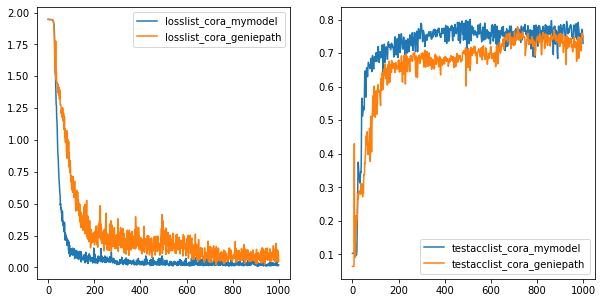

In [7]:
from matplotlib import pyplot as plt 
%matplotlib inline
f, ax = plt.subplots(1,2, figsize=(10,5), squeeze=False)

ax[0][0].plot(losslist_cora_mymodel,label="losslist_cora_mymodel")
ax[0][0].legend(loc=0, ncol=1) 
ax[0][1].plot(testacclist_cora_mymodel,label="testacclist_cora_mymodel")
ax[0][1].legend(loc=0, ncol=1) 
ax[0][0].plot(losslist_cora_geniepath,label="losslist_cora_geniepath")
ax[0][0].legend(loc=0, ncol=1) 
ax[0][1].plot(testacclist_cora_geniepath,label="testacclist_cora_geniepath")
ax[0][1].legend(loc=0, ncol=1) 
plt.savefig("gen_sgen在cora上对比")
plt.show()

# pubmed sgeniepath agnn

In [4]:
%%time
import argparse
import os.path as osp

import torch
from torch_geometric.datasets import PPI
from torch_geometric.data import DataLoader
from torch_geometric.nn import GATConv,AGNNConv
from sklearn.metrics import f1_score
from torch_geometric.datasets import Planetoid
import torch.nn.functional as F
import torch_geometric.transforms as T

# parser = argparse.ArgumentParser()
# parser.add_argument('--model', type=str, default='GeniePath')
# args = parser.parse_args()
# assert args.model in ['GeniePath', 'GeniePathLazy']

# path = osp.join(osp.dirname(osp.realpath(__file__)), 'data', 'PPI')
# train_dataset = PPI(path, split='train')
# val_dataset = PPI(path, split='val')
# test_dataset = PPI(path, split='test')
# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

dataset = 'Pubmed'
path = osp.join('./', '..', 'data', dataset)
dataset = Planetoid(path, dataset, T.NormalizeFeatures())
data = dataset[0]

# dim = dataset.num_features
# lstm_hidden = dataset.num_features
dim = 128
lstm_hidden = 128
layer_num = 3 #pubmed为3效果比较好，cora不能超过2,Citeseer不能超过1


class Breadth(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Breadth, self).__init__()
        self.gatconv = AGNNConv(requires_grad=True)
        # self.gatconv = GATConv(in_dim, out_dim,dropout=0.4, heads=1)#这里in_dim和out_dim都=dim=256

    def forward(self, x, edge_index):
        x=F.dropout(x, p=0.4, training=self.training)
        x = torch.tanh(self.gatconv(x, edge_index))
        return x


class Depth(torch.nn.Module):
    def __init__(self, in_dim, hidden):
        super(Depth, self).__init__()
        self.lstm = torch.nn.LSTM(in_dim, hidden, 1, bias=False)

    def forward(self, x, h, c):
        x=F.dropout(x, p=0.4, training=self.training)

        x, (h, c) = self.lstm(x, (h, c))
        return x, (h, c)


class GeniePathLayer(torch.nn.Module):
    def __init__(self, in_dim):
        super(GeniePathLayer, self).__init__()
        self.breadth_func = Breadth(in_dim, dim)
        self.depth_func = Depth(dim, lstm_hidden)

    def forward(self, x, edge_index, h, c):
        x = self.breadth_func(x, edge_index)
        x = x[None, :]
        x, (h, c) = self.depth_func(x, h, c)
        x = x[0]
        return x, (h, c)


class GeniePath(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePath, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.gplayers = torch.nn.ModuleList(
            [GeniePathLayer(dim) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x=F.dropout(x, p=0.4, training=self.training)

        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        for i, l in enumerate(self.gplayers):
            x, (h, c) = self.gplayers[i](x, edge_index, h, c)
        x = self.lin2(x)
        # return x
        return F.log_softmax(x, dim=1)



class GeniePathLazy(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePathLazy, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.breadths = torch.nn.ModuleList(
            [Breadth(dim, dim) for i in range(layer_num)])
        self.depths = torch.nn.ModuleList(
            [Depth(dim * 2, lstm_hidden) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        h_tmps = []
        for i, l in enumerate(self.breadths):
            h_tmps.append(self.breadths[i](x, edge_index))
        x = x[None, :]
        for i, l in enumerate(self.depths):
            in_cat = torch.cat((h_tmps[i][None, :], x), -1)
            x, (h, c) = self.depths[i](in_cat, h, c)
        x = self.lin2(x[0])
        return x


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kwargs = {'GeniePath': GeniePath, 'GeniePathLazy': GeniePathLazy}
# model = kwargs[args.model](train_dataset.num_features,train_dataset.num_classes).to(device)
loss_op = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model, data = GeniePath(dataset.num_features,dataset.num_classes).to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)


def train():
    model.train()
    optimizer.zero_grad()
    # loss = loss_op(model(data.x, data.edge_index), data.y)
    loss = F.nll_loss(model(data.x, data.edge_index)[data.train_mask], data.y[data.train_mask])
    # loss = loss_op(model(data.x, data.edge_index)[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss 


def test():
    model.eval()
    logits, accs = model(data.x, data.edge_index), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        a=logits[mask]
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

losslist_pubmed_mymodel,testacclist_pubmed_mymodel=[],[]
for epoch in range(1, 1001):
    loss = train()
    losslist_pubmed_mymodel.append(loss)
    testacclist_pubmed_mymodel.append(test()[2])
    # val_f1 = test(val_loader)
    # test_f1 = test(test_loader)
    # print('Epoch: {:02d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'.format(
    #     epoch, loss, val_f1, test_f1))
    log = 'Epoch: {:03d},train_loss:{:.7f}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    print(log.format(epoch, loss,*test()))
# from matplotlib import pyplot as plt 
# # %matplotlib inline

# plt.plot(losslist)
# plt.show()



"""
1000轮pubmed数据集效果
Epoch: 953,train_loss:0.0053930, Train: 1.0000, Val: 0.7780, Test: 0.7650
Epoch: 954,train_loss:0.0064971, Train: 1.0000, Val: 0.7780, Test: 0.7690
Epoch: 955,train_loss:0.0062360, Train: 1.0000, Val: 0.7760, Test: 0.7690
Epoch: 956,train_loss:0.0064282, Train: 1.0000, Val: 0.7800, Test: 0.7680
Epoch: 957,train_loss:0.0059630, Train: 1.0000, Val: 0.7820, Test: 0.7660
Epoch: 958,train_loss:0.0057412, Train: 1.0000, Val: 0.7880, Test: 0.7610
Epoch: 959,train_loss:0.0070204, Train: 1.0000, Val: 0.7900, Test: 0.7640
Epoch: 960,train_loss:0.0083166, Train: 1.0000, Val: 0.7920, Test: 0.7640
Epoch: 961,train_loss:0.0066219, Train: 1.0000, Val: 0.7880, Test: 0.7670
Epoch: 962,train_loss:0.0060282, Train: 1.0000, Val: 0.7860, Test: 0.7740
Epoch: 963,train_loss:0.0080318, Train: 1.0000, Val: 0.7840, Test: 0.7710
Epoch: 964,train_loss:0.0082156, Train: 1.0000, Val: 0.7780, Test: 0.7690
Epoch: 965,train_loss:0.0075362, Train: 1.0000, Val: 0.7780, Test: 0.7690
Epoch: 966,train_loss:0.0105927, Train: 1.0000, Val: 0.7780, Test: 0.7660
Epoch: 967,train_loss:0.0077958, Train: 1.0000, Val: 0.7820, Test: 0.7650
Epoch: 968,train_loss:0.0078789, Train: 1.0000, Val: 0.7800, Test: 0.7620
Epoch: 969,train_loss:0.0089889, Train: 1.0000, Val: 0.7800, Test: 0.7620
Epoch: 970,train_loss:0.0056428, Train: 1.0000, Val: 0.7840, Test: 0.7590
Epoch: 971,train_loss:0.0057153, Train: 1.0000, Val: 0.7860, Test: 0.7610
Epoch: 972,train_loss:0.0203651, Train: 1.0000, Val: 0.7820, Test: 0.7650
Epoch: 973,train_loss:0.0103905, Train: 1.0000, Val: 0.7820, Test: 0.7720
Epoch: 974,train_loss:0.0083350, Train: 1.0000, Val: 0.7780, Test: 0.7740
Epoch: 975,train_loss:0.0184127, Train: 1.0000, Val: 0.7840, Test: 0.7700
Epoch: 976,train_loss:0.0083088, Train: 1.0000, Val: 0.7900, Test: 0.7690
Epoch: 977,train_loss:0.0063906, Train: 1.0000, Val: 0.7860, Test: 0.7660
Epoch: 978,train_loss:0.0057222, Train: 1.0000, Val: 0.7860, Test: 0.7600
Epoch: 979,train_loss:0.0058686, Train: 1.0000, Val: 0.7780, Test: 0.7550
Epoch: 980,train_loss:0.0092487, Train: 1.0000, Val: 0.7780, Test: 0.7580
Epoch: 981,train_loss:0.0098447, Train: 1.0000, Val: 0.7780, Test: 0.7670
Epoch: 982,train_loss:0.0063194, Train: 1.0000, Val: 0.7920, Test: 0.7770
Epoch: 983,train_loss:0.0091629, Train: 1.0000, Val: 0.8000, Test: 0.7780
Epoch: 984,train_loss:0.0086891, Train: 1.0000, Val: 0.7960, Test: 0.7810
Epoch: 985,train_loss:0.0057028, Train: 1.0000, Val: 0.7900, Test: 0.7770
Epoch: 986,train_loss:0.0026957, Train: 1.0000, Val: 0.7820, Test: 0.7770
Epoch: 987,train_loss:0.0140978, Train: 1.0000, Val: 0.7820, Test: 0.7770
Epoch: 988,train_loss:0.0056254, Train: 1.0000, Val: 0.7800, Test: 0.7720
Epoch: 989,train_loss:0.0121286, Train: 1.0000, Val: 0.7800, Test: 0.7710
Epoch: 990,train_loss:0.0141445, Train: 1.0000, Val: 0.7880, Test: 0.7790
Epoch: 991,train_loss:0.0080615, Train: 1.0000, Val: 0.7900, Test: 0.7770
Epoch: 992,train_loss:0.0101339, Train: 1.0000, Val: 0.7760, Test: 0.7660
Epoch: 993,train_loss:0.0132652, Train: 1.0000, Val: 0.7740, Test: 0.7520
Epoch: 994,train_loss:0.0110487, Train: 1.0000, Val: 0.7760, Test: 0.7520
Epoch: 995,train_loss:0.0126923, Train: 1.0000, Val: 0.7860, Test: 0.7730
Epoch: 996,train_loss:0.0105120, Train: 1.0000, Val: 0.7940, Test: 0.7790
Epoch: 997,train_loss:0.0083987, Train: 1.0000, Val: 0.7900, Test: 0.7720
Epoch: 998,train_loss:0.0067350, Train: 1.0000, Val: 0.7520, Test: 0.7580
Epoch: 999,train_loss:0.0056399, Train: 1.0000, Val: 0.7420, Test: 0.7470
Epoch: 1000,train_loss:0.0237899, Train: 1.0000, Val: 0.7800, Test: 0.7710
CPU times: user 1min 1s, sys: 11.8 s, total: 1min 12s
Wall time: 1min 9s   


"""




sum([torch.numel(param) for param in model.parameters()])





Epoch: 001,train_loss:1.0988692, Train: 0.3333, Val: 0.1960, Test: 0.1800
Epoch: 002,train_loss:1.0986657, Train: 0.3333, Val: 0.1960, Test: 0.1800
Epoch: 003,train_loss:1.0986352, Train: 0.3333, Val: 0.1960, Test: 0.1800
Epoch: 004,train_loss:1.0984639, Train: 0.3333, Val: 0.1960, Test: 0.1800
Epoch: 005,train_loss:1.0985398, Train: 0.3333, Val: 0.4160, Test: 0.4070
Epoch: 006,train_loss:1.0985246, Train: 0.3333, Val: 0.4160, Test: 0.4070
Epoch: 007,train_loss:1.0983005, Train: 0.3333, Val: 0.4160, Test: 0.4070
Epoch: 008,train_loss:1.0983397, Train: 0.3333, Val: 0.4160, Test: 0.4070
Epoch: 009,train_loss:1.0982456, Train: 0.3333, Val: 0.4160, Test: 0.4070
Epoch: 010,train_loss:1.0982630, Train: 0.3333, Val: 0.4160, Test: 0.4070
Epoch: 011,train_loss:1.0982293, Train: 0.3333, Val: 0.4160, Test: 0.4070
Epoch: 012,train_loss:1.0981506, Train: 0.3333, Val: 0.4160, Test: 0.4070
Epoch: 013,train_loss:1.0979565, Train: 0.3333, Val: 0.4160, Test: 0.4070
Epoch: 014,train_loss:1.0978974, Train

457734

# Pubmed geniepath

In [5]:
%%time
import argparse
import os.path as osp

import torch
from torch_geometric.datasets import PPI
from torch_geometric.data import DataLoader
from torch_geometric.nn import GATConv,AGNNConv
from sklearn.metrics import f1_score
from torch_geometric.datasets import Planetoid
import torch.nn.functional as F
import torch_geometric.transforms as T

# parser = argparse.ArgumentParser()
# parser.add_argument('--model', type=str, default='GeniePath')
# args = parser.parse_args()
# assert args.model in ['GeniePath', 'GeniePathLazy']

# path = osp.join(osp.dirname(osp.realpath(__file__)), 'data', 'PPI')
# train_dataset = PPI(path, split='train')
# val_dataset = PPI(path, split='val')
# test_dataset = PPI(path, split='test')
# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

dataset = 'Pubmed'
path = osp.join('./', '..', 'data', dataset)
dataset = Planetoid(path, dataset, T.NormalizeFeatures())
data = dataset[0]

# dim = dataset.num_features
# lstm_hidden = dataset.num_features
dim = 128
lstm_hidden = 128
layer_num = 3  #pubmed为3效果比较好，cora不能超过2,Citeseer不能超过1


class Breadth(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Breadth, self).__init__()
        # self.gatconv = AGNNConv(requires_grad=True)
        self.gatconv = GATConv(in_dim, out_dim,dropout=0.4, heads=1)#这里in_dim和out_dim都=dim=256

    def forward(self, x, edge_index):
        x=F.dropout(x, p=0.4, training=self.training)
        x = torch.tanh(self.gatconv(x, edge_index))
        return x


class Depth(torch.nn.Module):
    def __init__(self, in_dim, hidden):
        super(Depth, self).__init__()
        self.lstm = torch.nn.LSTM(in_dim, hidden, 1, bias=False)

    def forward(self, x, h, c):
        x=F.dropout(x, p=0.4, training=self.training)

        x, (h, c) = self.lstm(x, (h, c))
        return x, (h, c)


class GeniePathLayer(torch.nn.Module):
    def __init__(self, in_dim):
        super(GeniePathLayer, self).__init__()
        self.breadth_func = Breadth(in_dim, dim)
        self.depth_func = Depth(dim, lstm_hidden)

    def forward(self, x, edge_index, h, c):
        x = self.breadth_func(x, edge_index)
        x = x[None, :]
        x, (h, c) = self.depth_func(x, h, c)
        x = x[0]
        return x, (h, c)


class GeniePath(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePath, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.gplayers = torch.nn.ModuleList(
            [GeniePathLayer(dim) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x=F.dropout(x, p=0.4, training=self.training)

        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        for i, l in enumerate(self.gplayers):
            x, (h, c) = self.gplayers[i](x, edge_index, h, c)
        x = self.lin2(x)
        # return x
        return F.log_softmax(x, dim=1)



class GeniePathLazy(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePathLazy, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.breadths = torch.nn.ModuleList(
            [Breadth(dim, dim) for i in range(layer_num)])
        self.depths = torch.nn.ModuleList(
            [Depth(dim * 2, lstm_hidden) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        h_tmps = []
        for i, l in enumerate(self.breadths):
            h_tmps.append(self.breadths[i](x, edge_index))
        x = x[None, :]
        for i, l in enumerate(self.depths):
            in_cat = torch.cat((h_tmps[i][None, :], x), -1)
            x, (h, c) = self.depths[i](in_cat, h, c)
        x = self.lin2(x[0])
        return x


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kwargs = {'GeniePath': GeniePath, 'GeniePathLazy': GeniePathLazy}
# model = kwargs[args.model](train_dataset.num_features,train_dataset.num_classes).to(device)
loss_op = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model, data = GeniePath(dataset.num_features,dataset.num_classes).to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)


def train():
    model.train()
    optimizer.zero_grad()
    # loss = loss_op(model(data.x, data.edge_index), data.y)
    loss = F.nll_loss(model(data.x, data.edge_index)[data.train_mask], data.y[data.train_mask])
    # loss = loss_op(model(data.x, data.edge_index)[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss 


def test():
    model.eval()
    logits, accs = model(data.x, data.edge_index), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        a=logits[mask]
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

losslist_pubmed_geniepath,testacclist_pubmed_geniepath=[],[]
for epoch in range(1, 1001):
    loss = train()
    losslist_pubmed_geniepath.append(loss)
    testacclist_pubmed_geniepath.append(test()[2])
    # val_f1 = test(val_loader)
    # test_f1 = test(test_loader)
    # print('Epoch: {:02d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'.format(
    #     epoch, loss, val_f1, test_f1))
    log = 'Epoch: {:03d},train_loss:{:.7f}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    print(log.format(epoch, loss,*test()))
# from matplotlib import pyplot as plt 
# %matplotlib inline
# f, ax = plt.subplots(1,2)

# ax[0][0].plot(losslist_cora_geniepath,label="losslist_cora_geniepath")
# ax[0][1].plot(testacclist_cora_geniepath,label="testacclist_cora_geniepath")
# plt.legend(loc=0, ncol=1) 
# plt.show()



"""
1000轮pubmed数据集效果
Epoch: 951,train_loss:0.0070723, Train: 1.0000, Val: 0.7540, Test: 0.7560
Epoch: 952,train_loss:0.0485079, Train: 1.0000, Val: 0.7520, Test: 0.7610
Epoch: 953,train_loss:0.0561940, Train: 1.0000, Val: 0.7480, Test: 0.7590
Epoch: 954,train_loss:0.0304516, Train: 1.0000, Val: 0.7460, Test: 0.7610
Epoch: 955,train_loss:0.0263838, Train: 1.0000, Val: 0.7520, Test: 0.7610
Epoch: 956,train_loss:0.0356006, Train: 1.0000, Val: 0.7540, Test: 0.7590
Epoch: 957,train_loss:0.0032032, Train: 1.0000, Val: 0.7500, Test: 0.7500
Epoch: 958,train_loss:0.0043785, Train: 1.0000, Val: 0.7540, Test: 0.7430
Epoch: 959,train_loss:0.0026555, Train: 1.0000, Val: 0.7520, Test: 0.7380
Epoch: 960,train_loss:0.0370542, Train: 1.0000, Val: 0.7560, Test: 0.7400
Epoch: 961,train_loss:0.0311677, Train: 1.0000, Val: 0.7600, Test: 0.7400
Epoch: 962,train_loss:0.0098415, Train: 1.0000, Val: 0.7580, Test: 0.7370
Epoch: 963,train_loss:0.0155770, Train: 1.0000, Val: 0.7520, Test: 0.7460
Epoch: 964,train_loss:0.0127602, Train: 1.0000, Val: 0.7560, Test: 0.7610
Epoch: 965,train_loss:0.0066608, Train: 1.0000, Val: 0.7560, Test: 0.7580
Epoch: 966,train_loss:0.0628939, Train: 1.0000, Val: 0.7520, Test: 0.7420
Epoch: 967,train_loss:0.0040972, Train: 1.0000, Val: 0.7540, Test: 0.7390
Epoch: 968,train_loss:0.0079601, Train: 1.0000, Val: 0.7560, Test: 0.7360
Epoch: 969,train_loss:0.0489217, Train: 1.0000, Val: 0.7500, Test: 0.7310
Epoch: 970,train_loss:0.0439227, Train: 1.0000, Val: 0.7400, Test: 0.7280
Epoch: 971,train_loss:0.0089715, Train: 1.0000, Val: 0.7340, Test: 0.7320
Epoch: 972,train_loss:0.1212230, Train: 1.0000, Val: 0.7460, Test: 0.7510
Epoch: 973,train_loss:0.0008306, Train: 1.0000, Val: 0.7440, Test: 0.7540
Epoch: 974,train_loss:0.0242602, Train: 1.0000, Val: 0.7560, Test: 0.7620
Epoch: 975,train_loss:0.0056071, Train: 1.0000, Val: 0.7580, Test: 0.7700
Epoch: 976,train_loss:0.0649902, Train: 1.0000, Val: 0.7540, Test: 0.7660
Epoch: 977,train_loss:0.0203555, Train: 1.0000, Val: 0.7460, Test: 0.7470
Epoch: 978,train_loss:0.0176302, Train: 1.0000, Val: 0.7440, Test: 0.7430
Epoch: 979,train_loss:0.0042343, Train: 1.0000, Val: 0.7420, Test: 0.7430
Epoch: 980,train_loss:0.0205396, Train: 1.0000, Val: 0.7420, Test: 0.7410
Epoch: 981,train_loss:0.0157316, Train: 1.0000, Val: 0.7500, Test: 0.7500
Epoch: 982,train_loss:0.0279756, Train: 1.0000, Val: 0.7500, Test: 0.7530
Epoch: 983,train_loss:0.0571950, Train: 1.0000, Val: 0.7540, Test: 0.7580
Epoch: 984,train_loss:0.0120400, Train: 1.0000, Val: 0.7660, Test: 0.7600
Epoch: 985,train_loss:0.0239784, Train: 1.0000, Val: 0.7600, Test: 0.7570
Epoch: 986,train_loss:0.0036942, Train: 1.0000, Val: 0.7560, Test: 0.7400
Epoch: 987,train_loss:0.0178741, Train: 1.0000, Val: 0.7540, Test: 0.7360
Epoch: 988,train_loss:0.0436260, Train: 1.0000, Val: 0.7540, Test: 0.7440
Epoch: 989,train_loss:0.0096762, Train: 1.0000, Val: 0.7560, Test: 0.7570
Epoch: 990,train_loss:0.0511418, Train: 1.0000, Val: 0.7520, Test: 0.7560
Epoch: 991,train_loss:0.0640492, Train: 1.0000, Val: 0.7540, Test: 0.7560
Epoch: 992,train_loss:0.0821633, Train: 1.0000, Val: 0.7520, Test: 0.7720
Epoch: 993,train_loss:0.0123788, Train: 1.0000, Val: 0.7520, Test: 0.7780
Epoch: 994,train_loss:0.0405142, Train: 1.0000, Val: 0.7560, Test: 0.7730
Epoch: 995,train_loss:0.0320284, Train: 1.0000, Val: 0.7520, Test: 0.7680
Epoch: 996,train_loss:0.0058501, Train: 1.0000, Val: 0.7460, Test: 0.7550
Epoch: 997,train_loss:0.0008803, Train: 1.0000, Val: 0.7440, Test: 0.7510
Epoch: 998,train_loss:0.0061166, Train: 1.0000, Val: 0.7440, Test: 0.7430
Epoch: 999,train_loss:0.0178923, Train: 1.0000, Val: 0.7440, Test: 0.7460
Epoch: 1000,train_loss:0.0212040, Train: 1.0000, Val: 0.7420, Test: 0.7480
CPU times: user 1min 10s, sys: 13.5 s, total: 1min 23s
Wall time: 1min 20s


"""
sum([torch.numel(param) for param in model.parameters()])


Epoch: 001,train_loss:1.0987858, Train: 0.3333, Val: 0.1960, Test: 0.1800
Epoch: 002,train_loss:1.0985430, Train: 0.3333, Val: 0.1960, Test: 0.1800
Epoch: 003,train_loss:1.0986981, Train: 0.3333, Val: 0.1960, Test: 0.1800
Epoch: 004,train_loss:1.0982529, Train: 0.3333, Val: 0.3920, Test: 0.4140
Epoch: 005,train_loss:1.0985991, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 006,train_loss:1.0984746, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 007,train_loss:1.0983033, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 008,train_loss:1.0983410, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 009,train_loss:1.0980265, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 010,train_loss:1.0982641, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 011,train_loss:1.0977628, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 012,train_loss:1.0981852, Train: 0.3333, Val: 0.3920, Test: 0.4150
Epoch: 013,train_loss:1.0981771, Train: 0.6500, Val: 0.5660, Test: 0.5280
Epoch: 014,train_loss:1.0980396, Train

508035

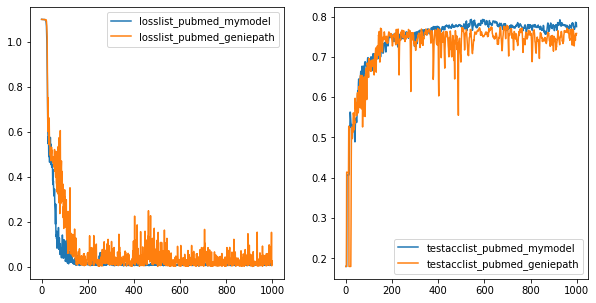

In [6]:
from matplotlib import pyplot as plt 
%matplotlib inline
f, ax = plt.subplots(1,2, figsize=(10,5), squeeze=False)

ax[0][0].plot(losslist_pubmed_mymodel,label="losslist_pubmed_mymodel")
ax[0][0].legend(loc=0, ncol=1) 
ax[0][1].plot(testacclist_pubmed_mymodel,label="testacclist_pubmed_mymodel")
ax[0][1].legend(loc=0, ncol=1) 
ax[0][0].plot(losslist_pubmed_geniepath,label="losslist_pubmed_geniepath")
ax[0][0].legend(loc=0, ncol=1) 
ax[0][1].plot(testacclist_pubmed_geniepath,label="testacclist_pubmed_geniepath")
ax[0][1].legend(loc=0, ncol=1) 
# plt.savefig("gen_sgen在pubmed上对比")
plt.show()

# Citeseer sgeniepath agnn

In [7]:
%%time
import argparse
import os.path as osp

import torch
from torch_geometric.datasets import PPI
from torch_geometric.data import DataLoader
from torch_geometric.nn import GATConv,AGNNConv
from sklearn.metrics import f1_score
from torch_geometric.datasets import Planetoid
import torch.nn.functional as F
import torch_geometric.transforms as T

# parser = argparse.ArgumentParser()
# parser.add_argument('--model', type=str, default='GeniePath')
# args = parser.parse_args()
# assert args.model in ['GeniePath', 'GeniePathLazy']

# path = osp.join(osp.dirname(osp.realpath(__file__)), 'data', 'PPI')
# train_dataset = PPI(path, split='train')
# val_dataset = PPI(path, split='val')
# test_dataset = PPI(path, split='test')
# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

dataset = 'Citeseer'
path = osp.join('./', '..', 'data', dataset)
dataset = Planetoid(path, dataset, T.NormalizeFeatures())
data = dataset[0]

# dim = dataset.num_features
# lstm_hidden = dataset.num_features
dim = 128
lstm_hidden = 128
layer_num = 1 #pubmed为3效果比较好，cora不能超过2,Citeseer不能超过1


class Breadth(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Breadth, self).__init__()
        self.gatconv = AGNNConv(requires_grad=True)
        # self.gatconv = GATConv(in_dim, out_dim,dropout=0.4, heads=1)#这里in_dim和out_dim都=dim=256

    def forward(self, x, edge_index):
        x=F.dropout(x, p=0.4, training=self.training)
        x = torch.tanh(self.gatconv(x, edge_index))
        return x


class Depth(torch.nn.Module):
    def __init__(self, in_dim, hidden):
        super(Depth, self).__init__()
        self.lstm = torch.nn.LSTM(in_dim, hidden, 1, bias=False)

    def forward(self, x, h, c):
        x=F.dropout(x, p=0.4, training=self.training)

        x, (h, c) = self.lstm(x, (h, c))
        return x, (h, c)


class GeniePathLayer(torch.nn.Module):
    def __init__(self, in_dim):
        super(GeniePathLayer, self).__init__()
        self.breadth_func = Breadth(in_dim, dim)
        self.depth_func = Depth(dim, lstm_hidden)

    def forward(self, x, edge_index, h, c):
        x = self.breadth_func(x, edge_index)
        x = x[None, :]
        x, (h, c) = self.depth_func(x, h, c)
        x = x[0]
        return x, (h, c)


class GeniePath(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePath, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.gplayers = torch.nn.ModuleList(
            [GeniePathLayer(dim) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x=F.dropout(x, p=0.4, training=self.training)

        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        for i, l in enumerate(self.gplayers):
            x, (h, c) = self.gplayers[i](x, edge_index, h, c)
        x = self.lin2(x)
        # return x
        return F.log_softmax(x, dim=1)



class GeniePathLazy(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePathLazy, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.breadths = torch.nn.ModuleList(
            [Breadth(dim, dim) for i in range(layer_num)])
        self.depths = torch.nn.ModuleList(
            [Depth(dim * 2, lstm_hidden) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        h_tmps = []
        for i, l in enumerate(self.breadths):
            h_tmps.append(self.breadths[i](x, edge_index))
        x = x[None, :]
        for i, l in enumerate(self.depths):
            in_cat = torch.cat((h_tmps[i][None, :], x), -1)
            x, (h, c) = self.depths[i](in_cat, h, c)
        x = self.lin2(x[0])
        return x


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kwargs = {'GeniePath': GeniePath, 'GeniePathLazy': GeniePathLazy}
# model = kwargs[args.model](train_dataset.num_features,train_dataset.num_classes).to(device)
loss_op = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model, data = GeniePath(dataset.num_features,dataset.num_classes).to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)


def train():
    model.train()
    optimizer.zero_grad()
    # loss = loss_op(model(data.x, data.edge_index), data.y)
    loss = F.nll_loss(model(data.x, data.edge_index)[data.train_mask], data.y[data.train_mask])
    # loss = loss_op(model(data.x, data.edge_index)[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss 


def test():
    model.eval()
    logits, accs = model(data.x, data.edge_index), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        a=logits[mask]
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

losslist_Citeseer_mymodel,testacclist_Citeseer_mymodel=[],[]
for epoch in range(1, 1001):
    loss = train()
    losslist_Citeseer_mymodel.append(loss)
    testacclist_Citeseer_mymodel.append(test()[2])
    # val_f1 = test(val_loader)
    # test_f1 = test(test_loader)
    # print('Epoch: {:02d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'.format(
    #     epoch, loss, val_f1, test_f1))
    log = 'Epoch: {:03d},train_loss:{:.7f}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    print(log.format(epoch, loss,*test()))
# from matplotlib import pyplot as plt 
# # %matplotlib inline

# plt.plot(losslist)
# plt.show()



"""
1000轮Citeseer数据集效果
Epoch: 987,train_loss:0.0229825, Train: 1.0000, Val: 0.6380, Test: 0.6320
Epoch: 988,train_loss:0.0355166, Train: 1.0000, Val: 0.6320, Test: 0.6320
Epoch: 989,train_loss:0.0285329, Train: 1.0000, Val: 0.6320, Test: 0.6420
Epoch: 990,train_loss:0.0338571, Train: 1.0000, Val: 0.6440, Test: 0.6490
Epoch: 991,train_loss:0.0253069, Train: 1.0000, Val: 0.6320, Test: 0.6440
Epoch: 992,train_loss:0.0278655, Train: 1.0000, Val: 0.6220, Test: 0.6400
Epoch: 993,train_loss:0.0319123, Train: 1.0000, Val: 0.6240, Test: 0.6400
Epoch: 994,train_loss:0.0279624, Train: 1.0000, Val: 0.6280, Test: 0.6350
Epoch: 995,train_loss:0.0284591, Train: 1.0000, Val: 0.6340, Test: 0.6490
Epoch: 996,train_loss:0.0282186, Train: 1.0000, Val: 0.6400, Test: 0.6490
Epoch: 997,train_loss:0.0270203, Train: 1.0000, Val: 0.6480, Test: 0.6440
Epoch: 998,train_loss:0.0306090, Train: 1.0000, Val: 0.6420, Test: 0.6420
Epoch: 999,train_loss:0.0247412, Train: 1.0000, Val: 0.6400, Test: 0.6460
Epoch: 1000,train_loss:0.0237779, Train: 1.0000, Val: 0.6480, Test: 0.6500
CPU times: user 18.1 s, sys: 1.05 s, total: 19.1 s
Wall time: 16.7 s


"""



sum([torch.numel(param) for param in model.parameters()])







Epoch: 001,train_loss:1.7923901, Train: 0.1667, Val: 0.1720, Test: 0.1820
Epoch: 002,train_loss:1.7918785, Train: 0.1667, Val: 0.1720, Test: 0.1820
Epoch: 003,train_loss:1.7913765, Train: 0.1667, Val: 0.1720, Test: 0.1820
Epoch: 004,train_loss:1.7909145, Train: 0.1667, Val: 0.1720, Test: 0.1820
Epoch: 005,train_loss:1.7905451, Train: 0.1667, Val: 0.1720, Test: 0.1820
Epoch: 006,train_loss:1.7899067, Train: 0.2667, Val: 0.2500, Test: 0.1930
Epoch: 007,train_loss:1.7898712, Train: 0.1667, Val: 0.2320, Test: 0.1810
Epoch: 008,train_loss:1.7895527, Train: 0.1833, Val: 0.2320, Test: 0.1810
Epoch: 009,train_loss:1.7889564, Train: 0.2417, Val: 0.2320, Test: 0.1830
Epoch: 010,train_loss:1.7885647, Train: 0.4000, Val: 0.3380, Test: 0.3560
Epoch: 011,train_loss:1.7865410, Train: 0.1917, Val: 0.2120, Test: 0.2320
Epoch: 012,train_loss:1.7863306, Train: 0.1750, Val: 0.2120, Test: 0.2320
Epoch: 013,train_loss:1.7846472, Train: 0.1917, Val: 0.2120, Test: 0.2320
Epoch: 014,train_loss:1.7832776, Train

605959

# Citeseer geniepath

In [8]:
%%time
import argparse
import os.path as osp

import torch
from torch_geometric.datasets import PPI
from torch_geometric.data import DataLoader
from torch_geometric.nn import GATConv,AGNNConv
from sklearn.metrics import f1_score
from torch_geometric.datasets import Planetoid
import torch.nn.functional as F
import torch_geometric.transforms as T

# parser = argparse.ArgumentParser()
# parser.add_argument('--model', type=str, default='GeniePath')
# args = parser.parse_args()
# assert args.model in ['GeniePath', 'GeniePathLazy']

# path = osp.join(osp.dirname(osp.realpath(__file__)), 'data', 'PPI')
# train_dataset = PPI(path, split='train')
# val_dataset = PPI(path, split='val')
# test_dataset = PPI(path, split='test')
# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

dataset = 'Citeseer'
path = osp.join('./', '..', 'data', dataset)
dataset = Planetoid(path, dataset, T.NormalizeFeatures())
data = dataset[0]

# dim = dataset.num_features
# lstm_hidden = dataset.num_features
dim = 128
lstm_hidden = 128
layer_num = 1  #pubmed为3效果比较好，cora不能超过2,Citeseer不能超过1


class Breadth(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Breadth, self).__init__()
        # self.gatconv = AGNNConv(requires_grad=True)
        self.gatconv = GATConv(in_dim, out_dim,dropout=0.4, heads=1)#这里in_dim和out_dim都=dim=256

    def forward(self, x, edge_index):
        x=F.dropout(x, p=0.4, training=self.training)
        x = torch.tanh(self.gatconv(x, edge_index))
        return x


class Depth(torch.nn.Module):
    def __init__(self, in_dim, hidden):
        super(Depth, self).__init__()
        self.lstm = torch.nn.LSTM(in_dim, hidden, 1, bias=False)

    def forward(self, x, h, c):
        x=F.dropout(x, p=0.4, training=self.training)

        x, (h, c) = self.lstm(x, (h, c))
        return x, (h, c)


class GeniePathLayer(torch.nn.Module):
    def __init__(self, in_dim):
        super(GeniePathLayer, self).__init__()
        self.breadth_func = Breadth(in_dim, dim)
        self.depth_func = Depth(dim, lstm_hidden)

    def forward(self, x, edge_index, h, c):
        x = self.breadth_func(x, edge_index)
        x = x[None, :]
        x, (h, c) = self.depth_func(x, h, c)
        x = x[0]
        return x, (h, c)


class GeniePath(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePath, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.gplayers = torch.nn.ModuleList(
            [GeniePathLayer(dim) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x=F.dropout(x, p=0.4, training=self.training)

        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        for i, l in enumerate(self.gplayers):
            x, (h, c) = self.gplayers[i](x, edge_index, h, c)
        x = self.lin2(x)
        # return x
        return F.log_softmax(x, dim=1)



class GeniePathLazy(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePathLazy, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.breadths = torch.nn.ModuleList(
            [Breadth(dim, dim) for i in range(layer_num)])
        self.depths = torch.nn.ModuleList(
            [Depth(dim * 2, lstm_hidden) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        h_tmps = []
        for i, l in enumerate(self.breadths):
            h_tmps.append(self.breadths[i](x, edge_index))
        x = x[None, :]
        for i, l in enumerate(self.depths):
            in_cat = torch.cat((h_tmps[i][None, :], x), -1)
            x, (h, c) = self.depths[i](in_cat, h, c)
        x = self.lin2(x[0])
        return x


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kwargs = {'GeniePath': GeniePath, 'GeniePathLazy': GeniePathLazy}
# model = kwargs[args.model](train_dataset.num_features,train_dataset.num_classes).to(device)
loss_op = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model, data = GeniePath(dataset.num_features,dataset.num_classes).to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)


def train():
    model.train()
    optimizer.zero_grad()
    # loss = loss_op(model(data.x, data.edge_index), data.y)
    loss = F.nll_loss(model(data.x, data.edge_index)[data.train_mask], data.y[data.train_mask])
    # loss = loss_op(model(data.x, data.edge_index)[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss 


def test():
    model.eval()
    logits, accs = model(data.x, data.edge_index), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        a=logits[mask]
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

losslist_Citeseer_geniepath,testacclist_Citeseer_geniepath=[],[]
for epoch in range(1, 1001):
    loss = train()
    losslist_Citeseer_geniepath.append(loss)
    testacclist_Citeseer_geniepath.append(test()[2])
    # val_f1 = test(val_loader)
    # test_f1 = test(test_loader)
    # print('Epoch: {:02d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'.format(
    #     epoch, loss, val_f1, test_f1))
    log = 'Epoch: {:03d},train_loss:{:.7f}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    print(log.format(epoch, loss,*test()))
# from matplotlib import pyplot as plt 
# %matplotlib inline
# f, ax = plt.subplots(1,2)

# ax[0][0].plot(losslist_cora_geniepath,label="losslist_cora_geniepath")
# ax[0][1].plot(testacclist_cora_geniepath,label="testacclist_cora_geniepath")
# plt.legend(loc=0, ncol=1) 
# plt.show()



"""
1000轮Citeseer数据集效果
Epoch: 987,train_loss:0.1055440, Train: 1.0000, Val: 0.6000, Test: 0.6270
Epoch: 988,train_loss:0.2827685, Train: 1.0000, Val: 0.6100, Test: 0.6190
Epoch: 989,train_loss:0.1982046, Train: 1.0000, Val: 0.6020, Test: 0.6260
Epoch: 990,train_loss:0.1708948, Train: 1.0000, Val: 0.6120, Test: 0.6150
Epoch: 991,train_loss:0.2397249, Train: 1.0000, Val: 0.6000, Test: 0.6070
Epoch: 992,train_loss:0.2047505, Train: 1.0000, Val: 0.6000, Test: 0.5970
Epoch: 993,train_loss:0.1261923, Train: 1.0000, Val: 0.5800, Test: 0.5860
Epoch: 994,train_loss:0.2088980, Train: 1.0000, Val: 0.5820, Test: 0.5920
Epoch: 995,train_loss:0.1436900, Train: 1.0000, Val: 0.5940, Test: 0.5970
Epoch: 996,train_loss:0.2564604, Train: 1.0000, Val: 0.6160, Test: 0.6130
Epoch: 997,train_loss:0.1209909, Train: 1.0000, Val: 0.6340, Test: 0.6390
Epoch: 998,train_loss:0.2647962, Train: 1.0000, Val: 0.6320, Test: 0.6460
Epoch: 999,train_loss:0.1605675, Train: 1.0000, Val: 0.6340, Test: 0.6450
Epoch: 1000,train_loss:0.1401642, Train: 1.0000, Val: 0.6240, Test: 0.6340
CPU times: user 20.9 s, sys: 967 ms, total: 21.9 s
Wall time: 19.1 s


"""
sum([torch.numel(param) for param in model.parameters()])



Epoch: 001,train_loss:1.7927133, Train: 0.1667, Val: 0.2320, Test: 0.1810
Epoch: 002,train_loss:1.7921691, Train: 0.1667, Val: 0.2320, Test: 0.1810
Epoch: 003,train_loss:1.7916572, Train: 0.1667, Val: 0.2320, Test: 0.1810
Epoch: 004,train_loss:1.7917211, Train: 0.1667, Val: 0.2320, Test: 0.1810
Epoch: 005,train_loss:1.7910351, Train: 0.1667, Val: 0.2320, Test: 0.1810
Epoch: 006,train_loss:1.7907796, Train: 0.1667, Val: 0.2320, Test: 0.1810
Epoch: 007,train_loss:1.7900548, Train: 0.1667, Val: 0.2320, Test: 0.1810
Epoch: 008,train_loss:1.7899803, Train: 0.1667, Val: 0.2320, Test: 0.1810
Epoch: 009,train_loss:1.7895981, Train: 0.1667, Val: 0.2320, Test: 0.1810
Epoch: 010,train_loss:1.7884063, Train: 0.1667, Val: 0.2320, Test: 0.1810
Epoch: 011,train_loss:1.7877656, Train: 0.1833, Val: 0.2320, Test: 0.1810
Epoch: 012,train_loss:1.7866204, Train: 0.3333, Val: 0.3500, Test: 0.3550
Epoch: 013,train_loss:1.7851262, Train: 0.2000, Val: 0.2200, Test: 0.2340
Epoch: 014,train_loss:1.7818829, Train

622726

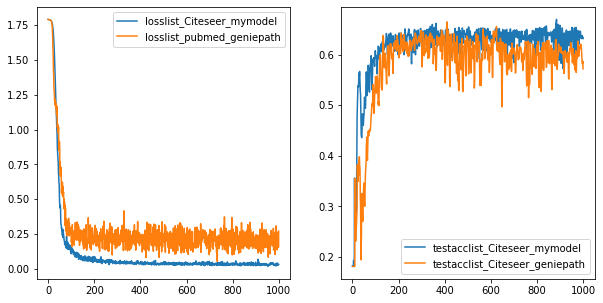

In [9]:
from matplotlib import pyplot as plt 
%matplotlib inline
f, ax = plt.subplots(1,2, figsize=(10,5), squeeze=False)

ax[0][0].plot(losslist_Citeseer_mymodel,label="losslist_Citeseer_mymodel")
ax[0][0].legend(loc=0, ncol=1) 
ax[0][1].plot(testacclist_Citeseer_mymodel,label="testacclist_Citeseer_mymodel")
ax[0][1].legend(loc=0, ncol=1) 
ax[0][0].plot(losslist_Citeseer_geniepath,label="losslist_pubmed_geniepath")
ax[0][0].legend(loc=0, ncol=1) 
ax[0][1].plot(testacclist_Citeseer_geniepath,label="testacclist_Citeseer_geniepath")
ax[0][1].legend(loc=0, ncol=1) 
# plt.savefig("gen_sgen在Citeseer上对比")
plt.show()